In [7]:
dir_path = "/content/drive/MyDrive/random_mask_unet"

In [8]:
!mkdir "/content/data/"
!mkdir "/content/data/train/"
!mkdir "/content/data/"
!mkdir "/content/data/test/"

mkdir: cannot create directory ‘/content/data/’: File exists
mkdir: cannot create directory ‘/content/data/train/’: File exists
mkdir: cannot create directory ‘/content/data/’: File exists
mkdir: cannot create directory ‘/content/data/test/’: File exists


In [9]:
cp -r "/content/drive/MyDrive/random_mask_unet/test/" "/content/data/test/"

In [10]:
# Imports
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import cv2

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
# Creating Generator
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(
        "/content/data/test/test/", target_size = (256, 256),color_mode = "rgb", batch_size = 50,class_mode = "input")

Found 6000 images belonging to 1 classes.


In [13]:
# Metric
def dice_coefficient(y_true, y_pred):
    y_true_flattened = keras.backend.flatten(y_true)
    y_pred_flattened = keras.backend.flatten(y_pred)
    x = keras.backend.sum(y_true_flattened * y_pred_flattened)
    y=keras.backend.sum(y_true_flattened + y_pred_flattened)
    return 2*x/y

In [14]:
# Model

class Generator():
  # UNET model
  def train_model(self, input_size=(256,256,3)):
    inputs = keras.layers.Input(input_size)
    acti_function = "relu"
    padding = "same"
    filters = 32
    kernel_size = (3,3)
    pool_size = (2,2)
    up_kernel = (2,2)
    up_stride = (2,2)
    # encoder 
    conv1, pooling1 = self.Convulation_layer(filters,kernel_size, pool_size, acti_function, padding, inputs)
    conv2, pooling2 = self.Convulation_layer(filters*2, kernel_size, pool_size, acti_function, padding, pooling1)
    conv3, pooling3 = self.Convulation_layer(filters*4, kernel_size, pool_size, acti_function,padding, pooling2) 
    conv4, pooling4 = self.Convulation_layer(filters*8, kernel_size, pool_size, acti_function,padding, pooling3) 
    # decoder 
    conv5, up6 = self.Up_Convulation_layer(filters*16, filters*8, kernel_size, up_kernel, up_stride, acti_function, padding, pooling4, conv4)
    conv6, up7 = self.Up_Convulation_layer(filters*8, filters*4, kernel_size, up_kernel, up_stride, acti_function,padding, up6, conv3)
    conv7, up8 = self.Up_Convulation_layer(filters*4, filters*2, kernel_size, up_kernel, up_stride, acti_function, padding, up7, conv2)
    conv8, up9 = self.Up_Convulation_layer(filters*2,filters, kernel_size, up_kernel, up_stride, acti_function,padding, up8, conv1)
    conv9 = keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(up9)
    conv9 = keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(conv9)
    outputs = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv9)
    return keras.models.Model(inputs=[inputs], outputs=[outputs]) 
    
  def Convulation_layer(self, filters, kernel_size, pool_size, activation, padding, connecting_layer, pool_layer=True):
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
    pooling = keras.layers.MaxPooling2D(pool_size)(conv)
    return conv, pooling

  def Up_Convulation_layer(self, filters, up_filters, kernel_size, up_kernel, up_stride, activation, padding, connecting_layer, shared_layer):
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
    up = keras.layers.Conv2DTranspose(filters=up_filters, kernel_size=up_kernel, strides=up_stride, padding=padding)(conv)
    up = keras.layers.concatenate([up, shared_layer], axis=3)
    return conv, up

In [15]:
# Compiling and plotting model
keras.backend.clear_session()
model = Generator().train_model()
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[dice_coefficient])
model.load_weights("/content/d9 (1).h5")

In [16]:
def getMask():
  # Generates a random mask
  mask = np.full((256,256,3), 255, np.uint8)
  mask_len = 64
  # x_mask = np.random.randint(50,256-mask_len-50)
  # y_mask = np.random.randint(50,256-mask_len-50)
  for i in range(3):
      for j in range(256):
          for k in range(256):
            if j>96 and 160>j and k>96 and 160>k:
              # if j>x_mask and x_mask+mask_len>j and k>y_mask and y_mask+mask_len>k:
              mask[j][k][i] = 1
  return mask

# Creating masks for images
def createmask(img):
  # Applies a mask on img
  img = img.astype(np.uint8)
  masked_image = np.copy(img)
  for l in range(len(img)):
    mask = getMask()
    masked_image[l] = cv2.bitwise_and(img[l], mask)
  return masked_image/255

In [ ]:
import sys
from tqdm import tqdm
mask = np.full((256,256,3), 255, np.uint8)

cnt = 0
for x,y in test_generator:
  x_mask = createmask(x)
  loss,metric = model.evaluate(x_mask,y/255)
  cnt += 1
  if cnt == 120:
    break
print(loss/120,metric/120)

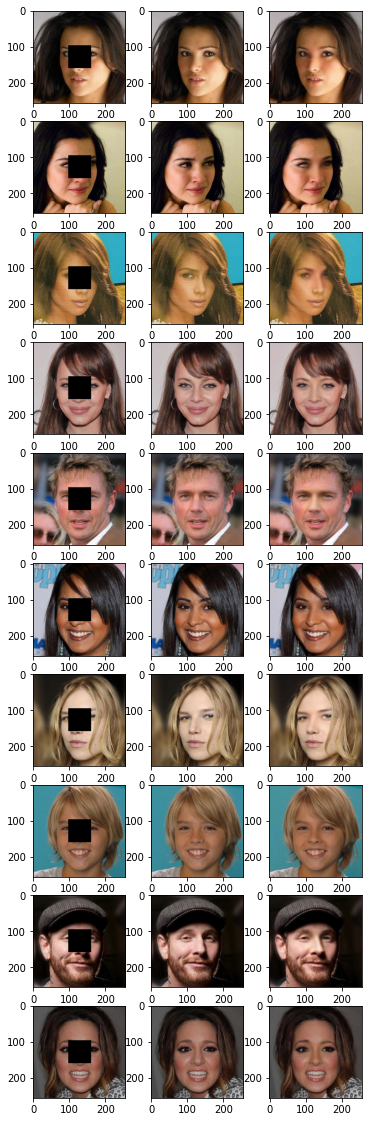

In [18]:
import matplotlib.pyplot as plt
rows = 10
fig, ax = plt.subplots(nrows=rows, ncols=3, figsize=(6, 2*rows))
for x,y in test_generator:
  x_mask = createmask(x)
  yhat = model.predict(x_mask)
  for i in range(rows):
    ax[i][0].imshow(x_mask[i])
    ax[i][1].imshow(y[i]/255)
    ax[i][2].imshow(yhat[i])
  break
plt.show()